[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [82]:
import os, operator
from typing import List, TypedDict, Annotated
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.messages import get_buffer_string
from IPython.display import Image, display, Markdown
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from prompt import *

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [85]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
# llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0) 

In [86]:
llm.invoke("Hello!").content

'Hello! How can I assist you today?'

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [87]:
# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [88]:
class Analyst(BaseModel):
    affiliation: str = Field(..., description="Primary affiliation of the analyst.")
    name: str = Field(..., description="Name of the analyst.")
    role: str = Field(..., description="Role of the analyst in the context of the topic.")
    description: str = Field(..., description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(..., description="Comprehensive list of analysts with their roles and affiliations.")

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [89]:
def create_analyst(state: GenerateAnalystsState) -> GenerateAnalystsState:
    """Create analysts """

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Enforce llm for structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System Message
    system_message = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )

    # Generate questions
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")]
    )

    # write list of analysts to state
    return { "analysts": analysts.analysts }


In [90]:
def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback is present
    if state.get("human_analyst_feedback", None):
        return "create_analyst"
    
    return END

In [91]:
# Build graph
graph = StateGraph(GenerateAnalystsState)

# Add nodes
graph.add_node("create_analyst", create_analyst)
graph.add_node("human_feedback", human_feedback)

# Add edges
graph.add_edge(START, "create_analyst")
graph.add_edge("create_analyst", "human_feedback")

# Conditionally loop back to create_analyst if human feedback is provided
graph.add_conditional_edges("human_feedback", should_continue, ["create_analyst", END])

# Compile graph
analystGraph = graph.compile(checkpointer=MemorySaver(), interrupt_before=["human_feedback"])

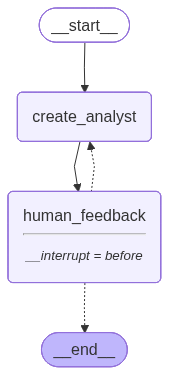

In [92]:
display(Image(analystGraph.get_graph().draw_mermaid_png()))

In [93]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in analystGraph.stream({ "topic":topic,"max_analysts":max_analysts }, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, exploring its architecture and how it enhances agent-based systems. She is particularly interested in performance metrics and scalability.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph, including its impact on data privacy and user trust. He advocates for responsible AI practices and the importance of transparency in AI frameworks.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Solutions Consultancy
Role: Business Strategy Consultant
Description: Ms. Thompson analyzes the business benefits of implementing LangGraph, focusing on cost efficiency, productivity improvements, and competitive advantages for organizations 

In [94]:
# Get state and look at next node
state = analystGraph.get_state(thread)
state.next

('human_feedback',)

In [95]:
# We now update the state as if we are the human_feedback node
analystGraph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e24f1-ef60-62c9-8002-80cce9d4751b'}}

In [96]:
# Continue the graph execution
for event in analystGraph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, exploring its architecture and how it enhances agent-based systems. She is particularly interested in performance metrics and scalability.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph, including its impact on data privacy and user trust. He advocates for responsible AI practices and the importance of transparency in AI frameworks.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Solutions Consultancy
Role: Business Strategy Consultant
Description: Ms. Thompson analyzes the business benefits of implementing LangGraph, focusing on cost efficiency, productivity improvements, and competitive advantages for organizations 

In [97]:
# If we are satisfied, then we simply supply no feedback
further_feedback = None
analystGraph.update_state(
    thread,
    { "human_analyst_feedback": further_feedback}, as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e24f2-6b38-6af4-8004-c3b04cf4b62a'}}

In [98]:
# Continue the graph execution to end
for event in analystGraph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [99]:
final_state = analystGraph.get_state(thread)
analysts = final_state.values.get('analysts')

In [100]:
final_state.next

()

In [101]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Tech Innovations Inc.
Role: AI Research Scientist
Description: Dr. Chen focuses on the technical advantages of LangGraph, exploring its capabilities in enhancing AI agent performance and efficiency. She is particularly interested in how LangGraph can streamline workflows and improve decision-making processes in complex environments.
--------------------------------------------------
Name: Michael Torres
Affiliation: Startup Hub
Role: Entrepreneur and Startup Founder
Description: Michael brings a startup perspective to the discussion, emphasizing the agility and scalability that LangGraph offers to new businesses. He is keen on how adopting this framework can provide startups with a competitive edge in rapidly evolving markets.
--------------------------------------------------
Name: Sarah Patel
Affiliation: Data Insights Group
Role: Data Analyst and Strategist
Description: Sarah specializes in the practical applications of LangGraph in data analysis an

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [102]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(..., description="Search query for retrieval.")

In [103]:
def generate_questions(state: InterviewState) -> InterviewState:
    """ Node to genrate interview questions based on context and previous messages """

    # Get state
    analyst = state['analyst']
    messages = state['messages']

    # Generate questions
    system_prompt = question_instructions.format(goals=analyst.persona)
    questions = llm.invoke(
        [SystemMessage(content=system_prompt)] + messages
    )

    # Write messages to state
    return { "messages": [questions] }

In [104]:
def web_search(state: InterviewState):
    """ Retrieve docs from web search. """

    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SystemMessage(content=search_instructions)] + state['messages']
    )

    # search
    tavily_search = TavilySearch(max_results=3)
    data = tavily_search.invoke({ "query": search_query.search_query })
    search_docs = data.get("results", data)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    # Write to state
    return { "context": [formatted_search_docs] }

def search_wikipedia(state: InterviewState):
    """ Retrieve docs from Wikipedia. """

    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SystemMessage(content=search_instructions)] + state['messages']
    )

    # search
    loader = WikipediaLoader(query=search_query.search_query, load_max_docs=2)
    docs = loader.load()

    # Format
    formatted_wiki_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    # Write to state
    return { "context": [formatted_wiki_docs] }

In [105]:
def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state['analyst']
    context = "\n\n---\n\n".join(state['context'])
    messages = state['messages']

    # Generate answer
    system_prompt = answer_instructions.format(
        goals=analyst.persona,
        context=context
    )
    answer = llm.invoke(
        [SystemMessage(content=system_prompt)] + messages
    )

    # Write messages to state
    return { "messages": [answer] }

def save_interview(state: InterviewState):

    """ Node to save interview transcript """

    # Get state
    messages = state['messages']

    # Format transcript
    transcript = get_buffer_string(messages)

    # Write to state
    return { "interview": transcript }

def route_messages(state: InterviewState, name: str = "expert"):
    """ Route between question and answer """

    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 2)

    # Check the number of expert answer
    num_responses = len([
        msg for msg in messages if isinstance(msg, AIMessage) and msg.name == name
    ])

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"
    
    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_message = messages[-2]

    if "Thank you so much for your help" in last_message.content:
        return 'save_interview'
    return "ask_question"

def write_section(state: InterviewState):
    """ Node to write out key sections from interview """

    # Get state
    interview = state['interview']
    context = state['context']
    analyst = state['analyst']

    # Generate sections
    system_prompt = section_writer_instructions.format(
        focus=analyst.description
    )
    sections = llm.invoke(
        [SystemMessage(content=system_prompt)] + 
        [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # Append it to state
    return { "sections": [sections.content] }

In [106]:
# Build graph
interview_graph = StateGraph(InterviewState)

# Add nodes
interview_graph.add_node("ask_question", generate_questions)
interview_graph.add_node("web_search", web_search)
interview_graph.add_node("search_wikipedia", search_wikipedia)
interview_graph.add_node("answer_question", generate_answer)
interview_graph.add_node("save_interview", save_interview)
interview_graph.add_node("write_section", write_section)

# Add edges
interview_graph.add_edge(START, "ask_question")
interview_graph.add_edge("ask_question", "web_search")
interview_graph.add_edge("ask_question", "search_wikipedia")
interview_graph.add_edge("web_search", "answer_question")
interview_graph.add_edge("search_wikipedia", "answer_question")
interview_graph.add_edge("answer_question", "save_interview")

# Conditionally route between question and answer
interview_graph.add_conditional_edges("answer_question", route_messages, ["ask_question", "save_interview"])

interview_graph.add_edge("save_interview", "write_section")
interview_graph.add_edge("write_section", END)

# Compile graph
interviewGraph = interview_graph.compile(checkpointer=MemorySaver()).with_config(run_name="Conduct Interview")

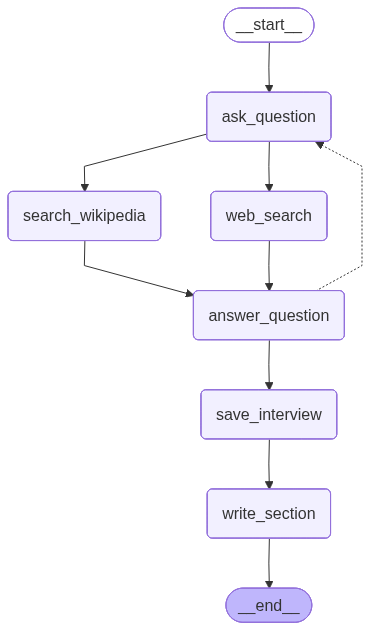

In [107]:
display(Image(interviewGraph.get_graph().draw_mermaid_png()))

In [108]:
analysts[0]

Analyst(affiliation='Tech Innovations Inc.', name='Dr. Emily Chen', role='AI Research Scientist', description='Dr. Chen focuses on the technical advantages of LangGraph, exploring its capabilities in enhancing AI agent performance and efficiency. She is particularly interested in how LangGraph can streamline workflows and improve decision-making processes in complex environments.')

In [109]:
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interviewGraph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Unleashing the Power of LangGraph: Transforming AI Agent Development

### Summary
Artificial Intelligence (AI) has revolutionized various sectors by enabling computational systems to perform tasks traditionally associated with human intelligence, such as learning, reasoning, and decision-making. Among the latest advancements in AI is LangGraph, a framework that enhances the development of AI agents by providing a visual workflow management system. This innovative approach allows developers to construct agent behaviors graphically, incorporating complex conditional branches and loops, which is particularly beneficial for managing intricate multi-step tasks. 

What sets LangGraph apart is its ability to streamline workflows and improve decision-making processes in complex environments. For instance, a recent study highlighted that generative AI, which can be integrated with LangGraph, increased productivity by up to 40% in writing tasks, showcasing the framework's potential to enhance efficiency in AI applications [1]. However, it is essential to note that the mere adoption of AI does not guarantee improved revenue or productivity, as evidenced by a study indicating that 95% of companies did not report any revenue growth from AI implementation [1]. 

LangGraph's unique features include its capability to create stateful, multi-agent applications powered by large language models (LLMs), which can automate workflows and synthesize real-time data [2]. This framework not only facilitates the development of AI agents that understand and generate human language but also integrates seamlessly with various tools and services, making it adaptable for diverse applications [3]. 

Moreover, LangGraph's orchestration capabilities allow for the design of agent-driven user experiences, enabling developers to build reliable and scalable AI systems [4]. As the demand for sophisticated AI solutions grows, LangGraph stands out as a pivotal tool for developers aiming to create intelligent systems that enhance user experience and operational efficiency.

1. [Applications of Artificial Intelligence](https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence)  
2. [Building Powerful AI Agents with LangGraph: A Complete Guide](https://pub.towardsai.net/building-powerful-ai-agents-with-langgraph-a-complete-guide-40d4c9f5ce0d)  
3. [Unlocking the Magic of Agentic Frameworks: Building Collaborative AI Teams with LangGraph](https://www.tribe.ai/applied-ai/unlocking-the-magic-of-agentic-frameworks-building-collaborative-ai-teams-with-langgraph)  
4. [Build AI Workflows with FastAPI & LangGraph: Step-by-Step Guide for 2025](https://www.zestminds.com/blog/build-ai-workflows-fastapi-langgraph/)  

### Sources
[1] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence  
[2] https://pub.towardsai.net/building-powerful-ai-agents-with-langgraph-a-complete-guide-40d4c9f5ce0d  
[3] https://www.tribe.ai/applied-ai/unlocking-the-magic-of-agentic-frameworks-building-collaborative-ai-teams-with-langgraph  
[4] https://www.zestminds.com/blog/build-ai-workflows-fastapi-langgraph/  

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [18]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [110]:
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [111]:
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')

    if human_analyst_feedback:
        # return to create_analyst node
        return "create_analyst"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state['topic']
        return [
            Send('conduct_interview', {
                "analyst": analyst,
                "messages": [HumanMessage(f"So you said you were writing an article on {topic}?")]
            }) for analyst in state['analysts']
        ]

In [112]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state['sections']
    topic = state['topic']

    # Concat all sections together
    formatted_sections = "\n\n---\n\n".join([f"{s}" for s in sections])

    # Summarize the sections into a final report
    system_prompt = report_writer_instructions.format(topic=topic, context=formatted_sections)
    report = llm.invoke(
        [SystemMessage(content=system_prompt)] + [HumanMessage(content="Write a report based upon these memos.") ]
    )

    return { "content": report.content }

In [113]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state['sections']
    topic = state['topic']

    # Concat all sections together
    formatted_sections = "\n\n---\n\n".join([f"{s}" for s in sections])

    # Summarize the sections into a final report
    system_prompt = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_sections)
    introduction = llm.invoke(
        [SystemMessage(content=system_prompt)] + [HumanMessage(content="Write an introduction for the report.") ]
    )

    return { "introduction": introduction.content }


def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state['sections']
    topic = state['topic']

    # Concat all sections together
    formatted_sections = "\n\n---\n\n".join([f"{s}" for s in sections])

    # Summarize the sections into a final report
    system_prompt = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_sections)
    conclusion = llm.invoke(
        [SystemMessage(content=system_prompt)] + [HumanMessage(content="Write a conclusion for the report.") ]
    )

    return { "conclusion": conclusion.content }

In [114]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [115]:
# build graph
research_graph = StateGraph(ResearchGraphState)

# add nodes
research_graph.add_node("create_analyst", create_analyst)
research_graph.add_node("human_feedback", human_feedback)
research_graph.add_node("conduct_interview", interview_graph.compile())
research_graph.add_node("write_report", write_report)
research_graph.add_node("write_introduction", write_introduction)
research_graph.add_node("write_conclusion", write_conclusion)
research_graph.add_node("finalize_report", finalize_report)

# add edges
research_graph.add_edge(START, "create_analyst")
research_graph.add_edge("create_analyst", "human_feedback")
research_graph.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analyst", "conduct_interview"])
research_graph.add_edge("conduct_interview", "write_report")
research_graph.add_edge("conduct_interview", "write_introduction")
research_graph.add_edge("conduct_interview", "write_conclusion")
research_graph.add_edge(["write_report", "write_introduction", "write_conclusion"], "finalize_report")
research_graph.add_edge("finalize_report", END)

# compile graph
workflow = research_graph.compile(checkpointer=MemorySaver(), interrupt_before=["human_feedback"])

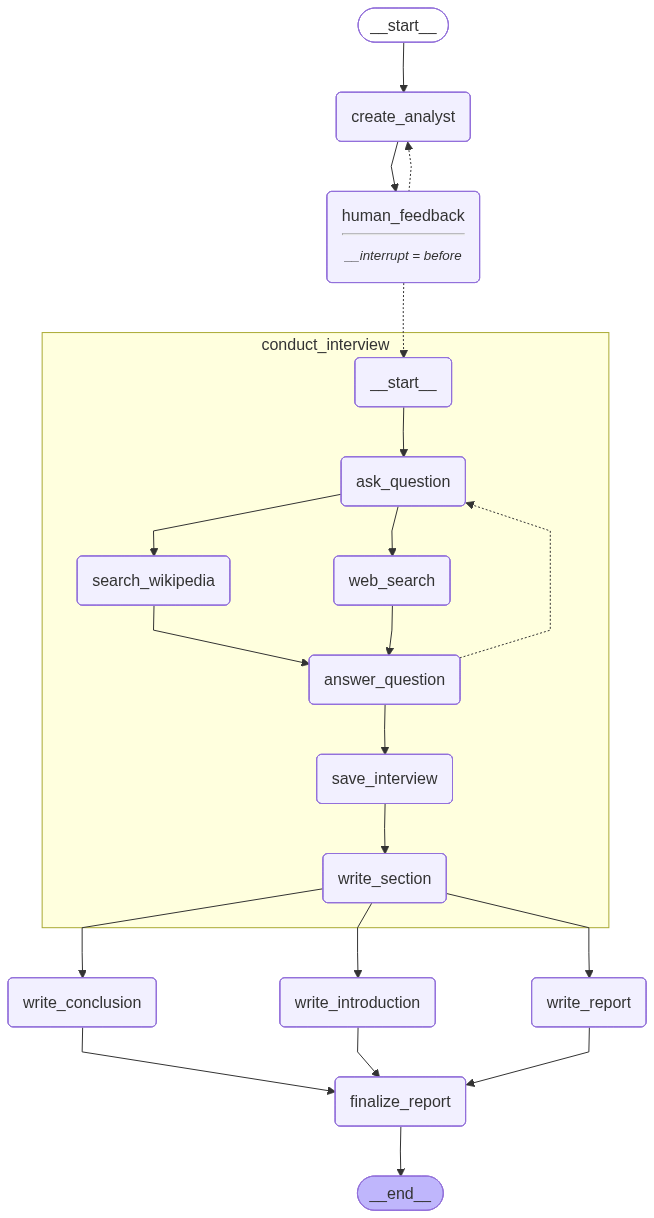

In [116]:
display(Image(workflow.get_graph(xray=1).draw_mermaid_png()))

In [118]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in workflow.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: Workplace Technology Analyst
Description: Mr. Liu examines the impact of adopting LangGraph on workplace productivity and collaboration. He is concerned with how this framework can facilitate better communication between AI agents and human workers, ultimately leading to improved outcomes in various industries.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Data-Driven Insights LLC
Role: Data Science Consultant
Description: Ms. Thompson investigates the data management capabiliti

In [120]:
# We now update the state as if we are the human_feedback node
workflow.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e251f-fda3-6a38-8002-8a583e7f4ff1'}}

In [121]:
# Check
for event in workflow.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: Workplace Technology Analyst
Description: Mr. Liu examines the impact of adopting LangGraph on workplace productivity and collaboration. He is concerned with how this framework can facilitate better communication between AI agents and human workers, ultimately leading to improved outcomes in various industries.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Data-Driven Insights LLC
Role: Data Science Consultant
Description: Ms. Thompson investigates the data management capabiliti

In [122]:
# Confirm we are happy
workflow.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e2520-edf8-680c-8004-78c764f372f3'}}

In [123]:
# Continue
for event in workflow.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [124]:
# Get final report
final_state = workflow.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

As artificial intelligence (AI) continues to advance, the demand for frameworks that enhance collaboration and streamline workflows among AI agents is paramount. LangGraph emerges as a transformative solution, offering a graph-based framework that simplifies the development of stateful multi-agent applications through visual workflow management. This report explores LangGraph's capabilities, including its support for real-time collaboration, integration with tools like React, and emphasis on developer experience. By examining its unique features, we highlight how LangGraph not only meets the growing needs of AI applications but also fosters innovation in the development landscape.

---


The adoption of LangGraph as an agent framework presents numerous benefits that enhance the development and functionality of AI agents. As the demand for sophisticated AI applications continues to rise, LangGraph's graph-based architecture allows developers to create complex workflows visually, moving away from traditional linear coding methods. This visual approach simplifies the design process and enables the incorporation of conditional branches and loops, which are essential for managing intricate tasks and facilitating backtracking when necessary [1][2][3].

A key advantage of LangGraph is its ability to support stateful, multi-agent applications effectively. This capability allows for the construction of agent behaviors that can adapt to dynamic environments, making it particularly suitable for applications requiring high levels of interaction and context retention, such as conversational agents [4][5]. The framework's integration with large language models (LLMs) further enhances its utility, enabling agents to synthesize real-time data and automate workflows, which significantly improves operational efficiency [6][7].

LangGraph also fosters real-time collaboration among AI agents, mimicking human teamwork and empowering agents to operate more effectively in multi-agent coordination scenarios. This collaborative capability is crucial for applications that require agents to simulate complex interactions based on predefined rules [8][9]. Additionally, the framework's emphasis on low-latency execution and compatibility with WebAssembly (WASM) positions it as a robust choice for enterprises seeking high-performance AI solutions [10][11].

Moreover, LangGraph prioritizes the developer experience (DX), ensuring that building and deploying AI agents is efficient and accessible to a broader range of developers, regardless of their technical background [12]. This focus on usability, combined with the community-driven nature of LangGraph, encourages collaboration and continuous improvement among developers, further enriching its ecosystem [13].

However, the framework also raises important considerations regarding the balance between control and autonomy in AI development. Developers must carefully navigate how much autonomy to grant their agents, as the predefined paths for agent behavior may limit spontaneous decision-making [14][15]. This ongoing debate highlights the need for a thoughtful approach to the design of intelligent, autonomous systems.

In summary, LangGraph represents a significant advancement in AI agent development, offering a versatile platform that meets the growing demands of modern applications. Its unique features, including visual workflow management, collaborative capabilities, and a strong emphasis on performance, position it as a leading choice for developers looking to create scalable, stateful AI systems.


---

## Conclusion

In conclusion, LangGraph emerges as a transformative framework for AI agent development, offering a unique blend of visual workflow management, stateful multi-agent capabilities, and a strong focus on developer experience. Its innovative graph-based architecture simplifies the creation of complex workflows, enabling real-time collaboration among agents and enhancing adaptability in dynamic environments. The integration with large language models and support for multi-agent systems further positions LangGraph as a versatile tool for modern AI applications. As organizations increasingly seek efficient and scalable AI solutions, adopting LangGraph will be pivotal in driving innovation and shaping the future of intelligent systems.

## Sources
[1] https://en.wikipedia.org/wiki/Semantic_Web  
[2] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[3] https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
[4] https://www.scalablepath.com/machine-learning/langgraph  
[5] https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant  
[6] https://www.gettingstarted.ai/langgraph-tutorial-with-example/  
[7] https://pramodaiml.medium.com/building-scalable-agent-systems-with-langgraph-best-practices-for-memory-streaming-durability-5eb360d162c3  
[8] https://www.tribe.ai/applied-ai/unlocking-the-magic-of-agentic-frameworks-building-collaborative-ai-teams-with-langgraph  
[9] https://medium.com/@kpetropavlov/building-a-multi-agent-developer-team-with-langchain-and-langgraph-c041060c1b18  
[10] https://blog.langchain.com/building-langgraph/  
[11] https://www.linkedin.com/posts/adnano_enterpriseai-agentframeworks-langgraph-activity-7320042017927942144-lS8d  
[12] https://prepzee.com/blog/building-ai-workflows-with-langchain-langgraph-n8n-and-autogen/  
[13] https://www.cohorte.co/blog/unleashing-the-power-of-langgraph-an-introduction-to-the-future-of-ai-workflows  
[14] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857  
[15] https://visagetechnologies.com/agent-framework-comparison-llamaindex-vs-langgraph-vs-adk/

Let's ask an open-ended question about LangGraph.

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r